In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [3]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

In [4]:
# print(plt.rcParams['font.family'])

plt.rcParams['font.family'] = 'NanumGothicCoding'
print(plt.rcParams['font.family'])

['NanumGothicCoding']


## load data

In [5]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'clean_merge.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'clean_meta.pkl'))

df_merge.shape, df_meta.shape

((1511955, 416), (1621, 15))

In [6]:
## save label encoder
with open(os.path.join(DATA_PATH, 'clean_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [7]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1400000 if x > 1400000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1400001, 200000), labels=np.arange(0,7))

In [8]:
# data
df_trn = df_merge[df_merge['ym'].isin(['201902', '201903', '201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

df_trn.shape, df_val.shape, df_tst.shape

((920573, 417), (254853, 417), (336529, 417))

In [9]:
df_list = [df_trn, df_val, df_tst]

In [10]:
label_cols = [c for c in df_trn.columns if 'label_' in c]

idx_col = 'svc_mgmt_num'
target_cols = ['label_mfact_nm', 'label_price_range', 'label_tablet_yn', 'label_note_yn', 'label_flagship_yn']

feature_cols = [c for c in df_trn.columns if c not in [idx_col, 'ym', 'next_ym'] + label_cols ]

## load model

In [11]:
label_dict = {
    'label_price_range': 'multi',
    'label_mfact_nm': 'multi',
    'label_tablet_yn': 'binary',
    'label_note_yn': 'binary',
    'label_flagship_yn': 'binary',
}

In [12]:
clf_dict = {}


for name in label_dict.keys():
    model_name = 'clf_' + '_'.join(name.split('_')[1:]) + '.pkl'
    with open(os.path.join(DATA_PATH, model_name), 'rb') as f:
        clf_dict[name] = pickle.load(f)

## predict

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

In [14]:
for label, p_type in label_dict.items():
    print('label: ', label)
    
    pred_col = 'pred_' + '_'.join(label.split('_')[1:])
    
    if p_type == 'multi':
        df_tst[pred_col] = clf_dict[label].predict(df_tst[feature_cols]).argmax(axis=1)
    else:
        df_tst[pred_col] = clf_dict[label].predict(df_tst[feature_cols])
        

label:  label_price_range
label:  label_mfact_nm
label:  label_tablet_yn
label:  label_note_yn
label:  label_flagship_yn


## shap

In [15]:
from shap_tools import ShapModule

In [17]:
df_trn.shape

(920573, 417)

In [18]:
df_trn.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
0    1004380709       1  44.0     44603.1667             3.0   
1    1005527212       2  34.0     58102.5000             0.0   
8    1130284006       1  47.0     50772.8889             0.0   
13   1155025407       1  57.0     23009.8571             0.0   
14   1170085805       1  73.0     34460.6667             0.0   

    last_eqp_buy_duration  tw_visit_days_fee_t_small  \
0                    74.0                        0.0   
1                   267.0                        0.0   
8                     0.0                        0.0   
13                  222.0                        0.0   
14                  522.0                        0.0   

    location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
0                          53.0                                 0.0   
1                          13.0                                 0.0   
8                          23.0                                 0.0   
13                          5.0                                 0.0   
14                         45.0                                 1.0   

    mbr_discount_amt_family_restaurant  ...  label_eqp_pet_nm  label_mfact_nm  \
0                                  0.0  ...            갤럭시S10               3   
1                              13575.0  ...            갤럭시S10               3   
8                                  0.0  ...            갤럭시S10               3   
13                                 0.0  ...               V50               1   
14                                 0.0  ...               V50               1   

    label_mktg_dt  label_tablet_yn  label_note_yn  label_disp_size_larg_yn  \
0        20190225                0              0                        0   
1        20190225                0              0                        0   
8        20190225                0              0                        0   
13       20190510                0              0                        1   
14       20190510                0              0                        1   

    label_flagship_yn  label_out_prc  label_prc_diff  label_price_range  
0                   1      1056000.0             0.0                  5  
1                   1      1056000.0             0.0                  5  
8                   1      1056000.0             0.0                  5  
13                  1      1199000.0             0.0                  5  
14                  1      1199000.0             0.0                  5  

[5 rows x 417 columns]

In [20]:
sm = ShapModule(df_trn, clf_dict['label_mfact_nm'], feature_cols, 'svc_mgmt_num', 'label_mfact_nm')

<class 'lightgbm.basic.Booster'>


In [21]:
sm.calculate_shap_value()

elapsed time:  135.05005025863647


In [22]:
sm.explainer.expected_value

[-3.534316382113353,
 -2.5868664138528126,
 -8.312281837520828,
 -0.02848711602325707]

In [25]:
sm.sample_df.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
svc_mgmt_num                                                             
7275028370     7275028370       1  28.0     38288.1250             0.0   
7257754737     7257754737       2  20.0     29467.7143             0.0   
7275196114     7275196114       2  13.0     35206.4444             0.0   
7246963660     7246963660       1  27.0     65241.5000             0.0   
7269264065     7269264065       2  10.0      9532.2222             3.0   

              last_eqp_buy_duration  tw_visit_days_fee_t_small  \
svc_mgmt_num                                                     
7275028370                      0.0                        0.0   
7257754737                      4.0                        0.0   
7275196114                      0.0                        0.0   
7246963660                    207.0                        0.0   
7269264065                    178.0                        0.0   

              location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
svc_mgmt_num                                                                    
7275028370                            4.0                                 0.0   
7257754737                            9.0                                 0.0   
7275196114                           10.0                                 0.0   
7246963660                           40.0                                 0.0   
7269264065                           43.0                                 0.0   

              mbr_discount_amt_family_restaurant  ...  label_eqp_pet_nm  \
svc_mgmt_num                                      ...                     
7275028370                                   0.0  ...             아이폰XS   
7257754737                                   0.0  ...              아이폰8   
7275196114                                   0.0  ...             아이폰XR   
7246963660                                   0.0  ...             아이폰XR   
7269264065                                   0.0  ...              아이폰7   

              label_mfact_nm  label_mktg_dt  label_tablet_yn  label_note_yn  \
svc_mgmt_num                                                                  
7275028370                 0       20181026                0              0   
7257754737                 0       20171027                0              0   
7275196114                 0       20181026                0              0   
7246963660                 0       20181026                0              0   
7269264065                 0       20161021                0              0   

              label_disp_size_larg_yn  label_flagship_yn  label_out_prc  \
svc_mgmt_num                                                              
7275028370                          0                  1      1364000.0   
7257754737                          0                  1      1142900.0   
7275196114                          0                  0       990000.0   
7246963660                          0                  0       990000.0   
7269264065                          0                  1       499400.0   

              label_prc_diff  label_price_range  
svc_mgmt_num                                     
7275028370               0.0                  6  
7257754737               0.0                  5  
7275196114               0.0                  4  
7246963660               0.0                  4  
7269264065          369600.0                  2  

[5 rows x 417 columns]

In [23]:
sm.sample_df_sv.shape

(100432, 401)

In [26]:
len(sm.sample_df_sv_list)

4

In [28]:
sm.df.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
svc_mgmt_num                                                             
1004380709     1004380709       1  44.0     44603.1667             3.0   
1005527212     1005527212       2  34.0     58102.5000             0.0   
1130284006     1130284006       1  47.0     50772.8889             0.0   
1155025407     1155025407       1  57.0     23009.8571             0.0   
1170085805     1170085805       1  73.0     34460.6667             0.0   

              last_eqp_buy_duration  tw_visit_days_fee_t_small  \
svc_mgmt_num                                                     
1004380709                     74.0                        0.0   
1005527212                    267.0                        0.0   
1130284006                      0.0                        0.0   
1155025407                    222.0                        0.0   
1170085805                    522.0                        0.0   

              location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
svc_mgmt_num                                                                    
1004380709                           53.0                                 0.0   
1005527212                           13.0                                 0.0   
1130284006                           23.0                                 0.0   
1155025407                            5.0                                 0.0   
1170085805                           45.0                                 1.0   

              mbr_discount_amt_family_restaurant  ...  label_eqp_pet_nm  \
svc_mgmt_num                                      ...                     
1004380709                                   0.0  ...            갤럭시S10   
1005527212                               13575.0  ...            갤럭시S10   
1130284006                                   0.0  ...            갤럭시S10   
1155025407                                   0.0  ...               V50   
1170085805                                   0.0  ...               V50   

              label_mfact_nm  label_mktg_dt  label_tablet_yn  label_note_yn  \
svc_mgmt_num                                                                  
1004380709                 3       20190225                0              0   
1005527212                 3       20190225                0              0   
1130284006                 3       20190225                0              0   
1155025407                 1       20190510                0              0   
1170085805                 1       20190510                0              0   

              label_disp_size_larg_yn  label_flagship_yn  label_out_prc  \
svc_mgmt_num                                                              
1004380709                          0                  1      1056000.0   
1005527212                          0                  1      1056000.0   
1130284006                          0                  1      1056000.0   
1155025407                          1                  1      1199000.0   
1170085805                          1                  1      1199000.0   

              label_prc_diff  label_price_range  
svc_mgmt_num                                     
1004380709               0.0                  5  
1005527212               0.0                  5  
1130284006               0.0                  5  
1155025407               0.0                  5  
1170085805               0.0                  5  

[5 rows x 417 columns]

In [37]:
sm.df.loc['1005527212'][sm.feature_cols]

sex_cd                                         2
age                                           34
real_avg_arpu                            58102.5
roaming_cnt_m3                                 0
last_eqp_buy_duration                        267
                                          ...   
days_from_svc_scrb_dt                       4846
days_from_fee_chg_dt                        1458
days_from_cncl_aply_last_equip_chg_dt       1012
days_from_eqp_acqr_dt                       1012
days_from_mktg_dt                           1279
Name: 1005527212, Length: 400, dtype: object

In [53]:
np.expand_dims(sm.df.loc['1005527212'][sm.feature_cols].values, axis=0).shape

(1, 400)

In [54]:
sm.explainer.shap_values(np.expand_dims(sm.df.loc['1005527212'][sm.feature_cols].values, axis=0))

[array([[ 8.50424400e-02,  2.68132740e-01, -4.07459410e-01,
         -2.94683588e-03, -3.39522543e-02, -1.09630472e-04,
          1.78707481e-03, -1.19394305e-05, -1.46614223e-06,
         -2.36451215e-05, -2.76352006e-04,  1.06525394e-04,
          1.35465983e-04, -2.04456510e-06, -7.33278801e-05,
          1.25427685e-04,  1.14851918e-05,  5.19261420e-03,
          0.00000000e+00, -1.15108020e-06,  0.00000000e+00,
          7.56798272e-03, -1.84788899e-04, -3.16882128e-04,
          2.75188342e-03, -2.36364281e-04,  0.00000000e+00,
          2.46286359e-04,  9.41228745e-02,  2.67866115e-01,
         -3.67640417e-05,  0.00000000e+00, -1.75178736e-05,
         -1.01354407e-02,  1.55002576e-02,  1.04810423e-02,
         -7.39813749e-06,  0.00000000e+00, -1.54696701e-04,
         -1.89435952e-05,  0.00000000e+00,  3.67077390e-04,
         -1.12120385e-04, -3.79651827e-05, -5.27436213e-05,
         -3.82570342e-04,  0.00000000e+00,  0.00000000e+00,
         -2.93266613e-04, -3.52537478e-04,  1.58651395e-03,
         -2.92662548e-04,  2.55453954e-04, -3.61916167e-06,
         -1.79702982e-03, -1.09144387e-04, -1.46502264e-05,
         -4.02814427e-05, -8.79112683e-06, -1.70334144e-02,
          1.15036008e-03,  0.00000000e+00, -1.26060166e-04,
         -4.21689454e-03, -3.86506305e-02,  1.35317267e-02,
          2.03480151e-03,  0.00000000e+00,  1.98720369e-03,
         -1.38513539e-03, -5.58876850e-03, -3.88965735e-05,
         -3.05062428e-05,  0.00000000e+00, -1.30247100e-06,
          1.40463266e-01,  0.00000000e+00,  0.00000000e+00,
          6.85181364e-04,  0.00000000e+00, -2.01688622e-06,
         -1.32869684e-05, -5.47966614e-05,  0.00000000e+00,
         -3.26985543e-04,  4.67203271e-05,  6.50585686e-03,
          0.00000000e+00, -1.07474726e-04,  1.63690876e-03,
          0.00000000e+00, -7.67865116e-04,  8.44674825e-05,
          1.06486507e-03, -2.03263259e-03,  2.04352559e-02,
         -2.43148396e-05,  5.96650323e-06, -5.51198143e-05,
          5.74148276e-04, -3.69266227e-06,  0.00000000e+00,
         -2.17220486e-06,  7.49859713e-05,  4.84837312e-05,
         -5.73896766e-05,  2.40814617e-02,  0.00000000e+00,
         -3.18968704e-05,  0.00000000e+00, -1.37277328e-06,
         -4.36148867e-04,  4.50262031e-03,  1.01945995e-04,
         -3.34649698e-05,  3.06467406e-02,  3.05323454e-03,
          0.00000000e+00,  3.16464809e-02,  1.40345646e-03,
          1.49104405e-02,  0.00000000e+00,  0.00000000e+00,
         -3.58288457e-02,  6.49639907e-04, -1.20866625e-03,
         -3.68234614e-06,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  9.87117868e-04, -3.41299772e-05,
          0.00000000e+00, -2.11860392e-05,  0.00000000e+00,
         -2.57550631e-02,  0.00000000e+00, -1.86073041e-03,
         -3.63248825e-03, -1.47154302e-05, -2.15045410e-03,
         -1.23729797e-05,  4.52232524e-03, -2.63914665e-02,
         -7.77979678e-05,  1.88970909e-03,  0.00000000e+00,
         -1.58663060e-04, -2.95424155e-03,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -3.27546033e-06,  2.31645420e-04, -5.79134422e-07,
         -4.88612965e-06,  1.61912949e-03,  2.14947543e-04,
          0.00000000e+00,  4.28020549e-04,  4.41428735e-02,
         -4.34539690e-05,  0.00000000e+00,  3.14071406e-03,
         -5.62285387e-04, -2.13728141e-06, -2.10824528e-04,
          0.00000000e+00, -1.92806330e-06, -1.28466822e-04,
         -2.06937484e-04, -7.07704425e-04, -3.13964540e-04,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -3.22512283e-03, -3.98454773e-04, -2.06866848e-03,
         -9.32332197e-03,  1.70447801e-03, -2.42309016e-04,
          1.86826880e-04, -8.47692696e-05, -1.39966590e-06,
          0.00000000e+00, -2.32078320e-06, -2.96503941e-03,
         -3.08937305e-06, -1.15188400e-05, -9.78542958e-06,
         -2.38535953e-06, -7.80764203e-05, -1.00589797e-03,
          0.00000000e+00,  2.43062290e-0

shap_value

In [55]:
svc_mgmt_num = None

In [56]:
prod_meta = None

In [59]:
if svc_mgmt_num is None:
    svc_mgmt_num = sm.df.iloc[random.randint(
        0, sm.df.shape[0])][sm.idx_col]
if prod_meta is not None:
    class_label = list(prod_meta.loc[class_label]['prod_nm'])
else:
    class_label = list(sm.df[sm.target_col].value_counts().index)

In [60]:
class_label

[3, 0, 1, 2]

In [58]:
import random

In [ ]:
np.expand_dims(sm.df.loc['1005527212'][sm.feature_cols].values

In [61]:
tmp_shap = sm.explainer.shap_values(, axis=0))
cnt = tmp_shap[0].shape[0]

In [62]:
cnt

1

In [64]:
len(tmp_shap)

4

In [ ]:
for x in range(len(class_label)):
    tmp_shap[x] = tmp_shap[x].reshape(1, cnt)
row_index = 0

In [67]:
row_index = 0

In [69]:
sm.df.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
svc_mgmt_num                                                             
1004380709     1004380709       1  44.0     44603.1667             3.0   
1005527212     1005527212       2  34.0     58102.5000             0.0   
1130284006     1130284006       1  47.0     50772.8889             0.0   
1155025407     1155025407       1  57.0     23009.8571             0.0   
1170085805     1170085805       1  73.0     34460.6667             0.0   

              last_eqp_buy_duration  tw_visit_days_fee_t_small  \
svc_mgmt_num                                                     
1004380709                     74.0                        0.0   
1005527212                    267.0                        0.0   
1130284006                      0.0                        0.0   
1155025407                    222.0                        0.0   
1170085805                    522.0                        0.0   

              location_weekday_visit_dong  mbr_discount_cnt_convenience_store  \
svc_mgmt_num                                                                    
1004380709                           53.0                                 0.0   
1005527212                           13.0                                 0.0   
1130284006                           23.0                                 0.0   
1155025407                            5.0                                 0.0   
1170085805                           45.0                                 1.0   

              mbr_discount_amt_family_restaurant  ...  label_eqp_pet_nm  \
svc_mgmt_num                                      ...                     
1004380709                                   0.0  ...            갤럭시S10   
1005527212                               13575.0  ...            갤럭시S10   
1130284006                                   0.0  ...            갤럭시S10   
1155025407                                   0.0  ...               V50   
1170085805                                   0.0  ...               V50   

              label_mfact_nm  label_mktg_dt  label_tablet_yn  label_note_yn  \
svc_mgmt_num                                                                  
1004380709                 3       20190225                0              0   
1005527212                 3       20190225                0              0   
1130284006                 3       20190225                0              0   
1155025407                 1       20190510                0              0   
1170085805                 1       20190510                0              0   

              label_disp_size_larg_yn  label_flagship_yn  label_out_prc  \
svc_mgmt_num                                                              
1004380709                          0                  1      1056000.0   
1005527212                          0                  1      1056000.0   
1130284006                          0                  1      1056000.0   
1155025407                          1                  1      1199000.0   
1170085805                          1                  1      1199000.0   

              label_prc_diff  label_price_range  
svc_mgmt_num                                     
1004380709               0.0                  5  
1005527212               0.0                  5  
1130284006               0.0                  5  
1155025407               0.0                  5  
1170085805               0.0                  5  

[5 rows x 417 columns]

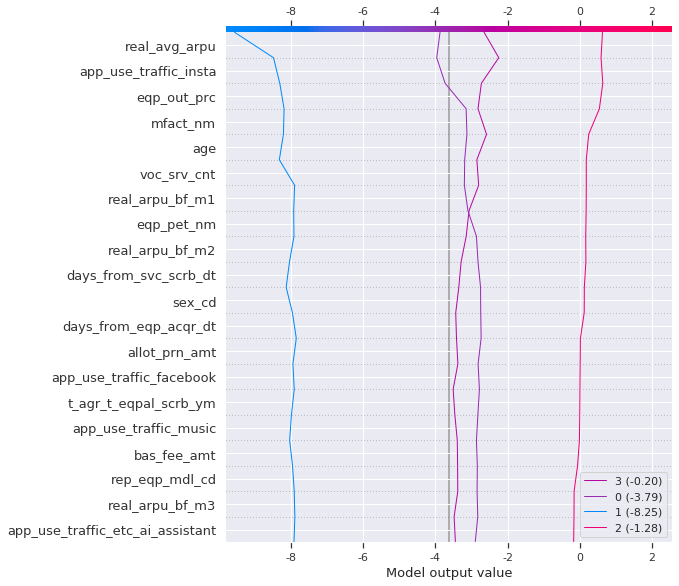

In [70]:
shap.multioutput_decision_plot(list(sm.explainer.expected_value), tmp_shap, row_index, 
                               feature_names=sm.feature_cols, 
                               legend_labels=sm.class_labels(row_index, class_label))


In [71]:
sm.force_plot_custom()

calculate predict score by your self
model prediction score is : 0.0 
real target value was [3]


In [72]:
sm.multiclass_summary_plot_for_confusion_matrix()

AttributeError: 'DataFrame' object has no attribute 'prediction'

IndexError: index 100340 is out of bounds for axis 0 with size 99998

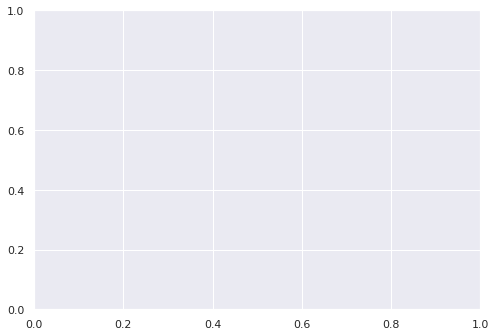

In [74]:
sm.summary_plot()

In [77]:
sm.summary_plot(shap_values[0], df_sample, feature_names=feature_cols,  max_display=20)

AttributeError: 'ShapModule' object has no attribute 'shap_values'

In [ ]:
shap.summary_plot(self.sample_df_sv[self.sample_df_sv[self.target_col] == val][self.feature_cols].values,
                  sample[sample[self.target_col] == val][self.feature_cols].values, 
                  feature_names=self.feature_cols, max_display=max_display, auto_size_plot=False, show=False)